---
title: PRISM Algorithm 2
authors: [gvarnavides]
date: 2025-01-26
---

In [1]:
%matplotlib widget
import py4DSTEM
import abtem
import ase

import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

abtem.config.set({"dask.lazy":False});

## Multislice

In [18]:
Si3N4_crystal = ase.Atoms(
    "Si6N8",
    scaled_positions=[
        (0.82495, 0.59387, 0.75),
        (0.23108, 0.82495, 0.25),
        (0.59387, 0.76892, 0.25),
        (0.40614, 0.23108, 0.75),
        (0.76892, 0.17505, 0.75),
        (0.17505, 0.40613, 0.25),
        
        (0.66667, 0.33334, 0.75),
        (0.33334, 0.66667, 0.25),
        (0.66986, 0.70066, 0.75),
        (0.96920, 0.66986, 0.25),
        (0.70066, 0.03081, 0.25),
        (0.29934, 0.96919, 0.75),
        (0.33015, 0.29934, 0.25),
        (0.03081, 0.33014, 0.75),
    ],
    cell=[7.6045, 7.6045, 2.9052, 90, 90, 120],
    pbc=True
)

Si3N4_orthorhombic = abtem.orthogonalize_cell(Si3N4_crystal)
Si3N4_orthorhombic *= (3,2,17)

In [176]:
potential = abtem.Potential(
    Si3N4_orthorhombic,
    # sampling = 0.2,
    gpts = (128,144),
    slice_thickness = Si3N4_orthorhombic.cell[2,2]/32,
    parametrization = 'lobato',
    projection = 'finite',
).build(
)

In [178]:
s_matrix_1 = abtem.SMatrix(
    potential=potential,
    energy=300e3,
    semiangle_cutoff=20,
    downsample=None,
    interpolation=1,
).build(
)


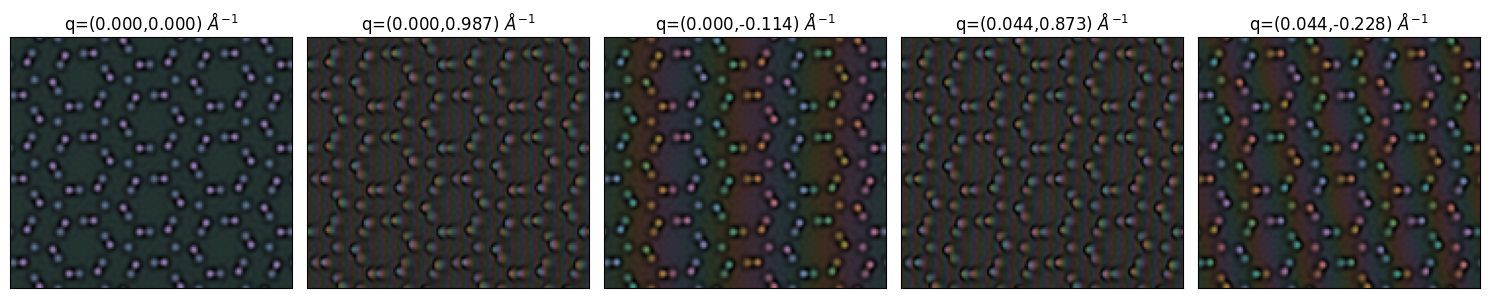

In [227]:
#| label: prism_multislice

delta = 26
arrays = s_matrix_1.waves[:5*delta:delta].array
wavevectors = s_matrix_1.waves[:5*delta:delta].ensemble_axes_metadata[0].values
titles = [f"q=({kx:.3f},{ky:.3f})"+r" $\AA^{-1}$" for kx,ky in wavevectors]

with plt.ioff():
    py4DSTEM.show_complex(
        arrays,
        title=titles,
        vmin=0,vmax=1,
        ticks=False,
        cbar=False,
        axsize=(3,3)
    )
plt.gcf()  

## Interpolation Factor

In [228]:
s_matrix_2 = abtem.SMatrix(
    potential=potential,
    energy=300e3,
    semiangle_cutoff=20,
    downsample=None,
    interpolation=2,
).build(
)

s_matrix_3 = abtem.SMatrix(
    potential=potential,
    energy=300e3,
    semiangle_cutoff=20,
    downsample=None,
    interpolation=3,
).build(
)

s_matrix_4 = abtem.SMatrix(
    potential=potential,
    energy=300e3,
    semiangle_cutoff=20,
    downsample=None,
    interpolation=4,
).build(
)

s_matrix_6 = abtem.SMatrix(
    potential=potential,
    energy=300e3,
    semiangle_cutoff=20,
    downsample=None,
    interpolation=6,
).build(
)

The interpolation factor does not exactly divide 'gpts', normalization may not be exactly preserved.
The interpolation factor does not exactly divide 'gpts', normalization may not be exactly preserved.
The interpolation factor does not exactly divide 'gpts', normalization may not be exactly preserved.
The interpolation factor does not exactly divide 'gpts', normalization may not be exactly preserved.


In [241]:
probe_arrays = [
    s.reduce(
        scan=abtem.CustomScan(np.array(potential.extent)/2),
        ctf=abtem.CTF(defocus=100),
        detectors=abtem.WavesDetector()
    ).array[0]
    for s in (s_matrix_1,s_matrix_2,s_matrix_3,s_matrix_4,s_matrix_6)
]

probe_fourier_arrays = [np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(arr))) for arr in probe_arrays]

probe_titles = [f"interpolation factor: {f}" for f in (1,2,3,4,6)]

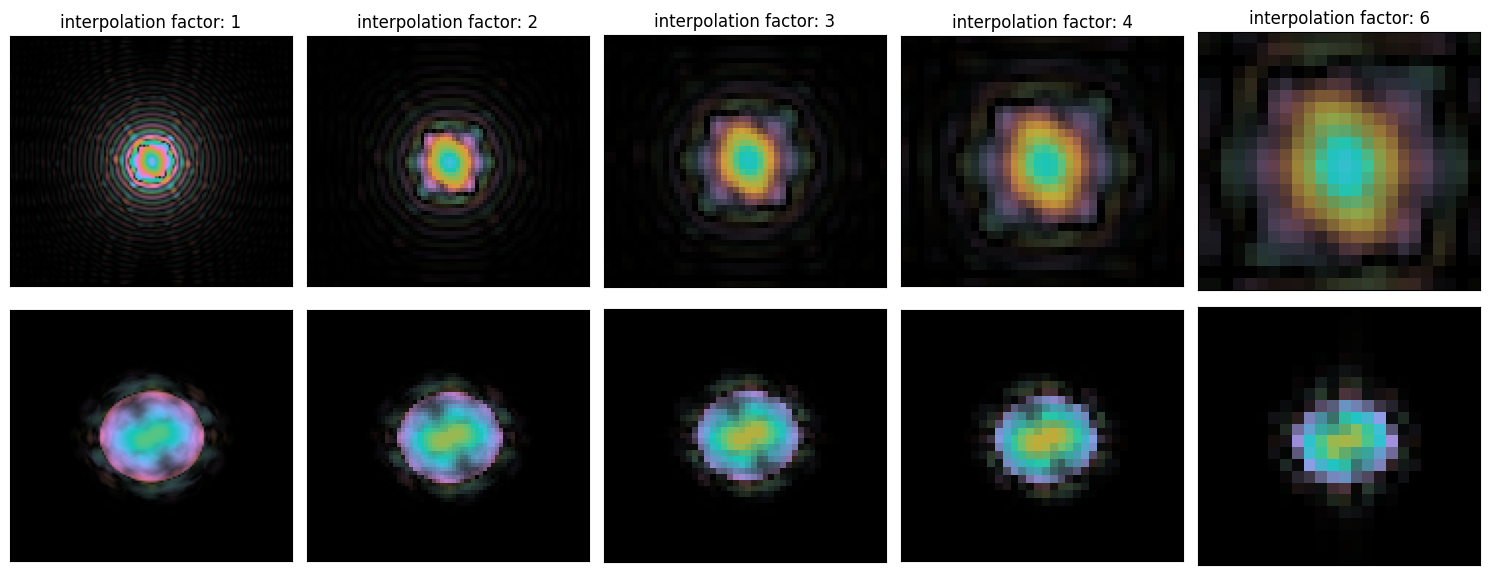

In [242]:
#| label: prism_interpolation_factor

with plt.ioff():
    py4DSTEM.show_complex(
        [
            probe_arrays,
            probe_fourier_arrays
        ],
        ticks=False,
        cbar=False,
        title=probe_titles,
        axsize=(3,3),
    )
plt.gcf()